In [1]:
#Cargado de datos
import pandas as pd

data= pd.read_csv('df_clean.csv')

print(data.head())

      video_id trending_date  \
0  Jw1Y-zhQURU    2017-11-14   
1  3s1rvMFUweQ    2017-11-14   
2  n1WpP7iowLc    2017-11-14   
3  PUTEiSjKwJU    2017-11-14   
4  rHwDegptbI4    2017-11-14   

                                               title  \
0      John Lewis Christmas Ad 2017 - #MozTheMonster   
1          Taylor Swift: …Ready for It? (Live) - SNL   
2         Eminem - Walk On Water (Audio) ft. Beyoncé   
3  Goals from Salford City vs Class of 92 and Fri...   
4  Dashcam captures truck's near miss with child ...   

                channel_title category_id              publish_time  \
0                  John Lewis          26  2017-11-10T07:38:29.000Z   
1         Saturday Night Live          24  2017-11-12T06:24:44.000Z   
2                  EminemVEVO          10  2017-11-10T17:00:03.000Z   
3  Salford City Football Club          17  2017-11-13T02:30:38.000Z   
4            Cute Girl Videos          25  2017-11-13T01:45:13.000Z   

                                           

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [14]:
print("\nCantidad de filas y columnas en el DataFrame:")
print(data.shape)


Cantidad de filas y columnas en el DataFrame:
(38623, 3)


In [16]:
#Eliminamos las columnas que no usaremos para nuestra predicción
data = data.drop(columns=['publish_time','lat','category_id','lon','tags','comment_count', 'thumbnail_link','comments_disabled','ratings_disabled','video_error_or_removed','video_error_or_removed','description','state','geometry','video_id','trending_date','channel_title','category_name','title'])
print(data.shape)

(38623, 3)


In [17]:
data.head()

,views,likes,dislikes
0,7224515.0,55681.0,10247.0
1,1053632.0,25561.0,2294.0
2,17158579.0,787420.0,43420.0
3,27833.0,193.0,12.0
4,9815.0,30.0,2.0


## Obtener conjunto de datos de Entrenamiento (Train) y de Prueba (Test)


In [18]:
from sklearn.model_selection import train_test_split

In [20]:
for column in ['views', 'likes', 'dislikes']:
    data[column] = data[column].fillna(data[column].mode()[0]) 

data.isna().sum().sort_values()

views       0
likes       0
dislikes    0
dtype: int64

In [21]:
X = data[['likes','dislikes']]
y = data['views']

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=101)

In [23]:
#Creando y entrenando el modelo
from sklearn.linear_model import LinearRegression

In [24]:
lm = LinearRegression()

In [25]:
lm.fit(X_train, y_train)

LinearRegression()

In [26]:
slope = lm.coef_  # w1
intercept = lm.intercept_ # w0

print("Las pendientes 'w1' del modelo son: ", slope)
print("El término independiente de la recta 'w0' es: ", intercept)

Las pendientes 'w1' del modelo son:  [42.25131138 38.82472545]
El término independiente de la recta 'w0' es:  41829.41236795485


In [27]:
coef_df = pd.DataFrame(lm.coef_,X.columns,columns=['Coeficiente'])
coef_df

,Coeficiente
likes,42.251311
dislikes,38.824725


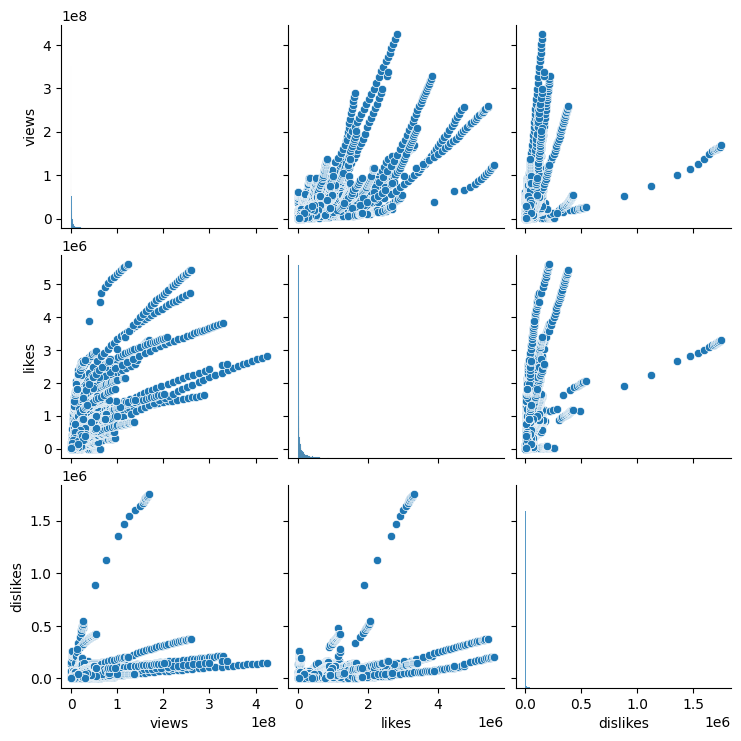

In [28]:
sns.pairplot(data)

**¿Cómo interpretar estos coeficientes?**

Interpretación de los coeficientes:

- Manteniendo todas las demás características fijas, el aumento de 1 **Like** está asociado con el **aumento de 42.251311 vistas**.
- - Manteniendo todas las demás características fijas, el aumento de 1 **Dislike** está asociado con el **aumento de 38.824725 vistas**.

## Entrenamiento y predicción

In [31]:
from sklearn.linear_model import LogisticRegression

In [32]:

logmodel = LogisticRegression(solver='lbfgs', max_iter=1000) #Parametros utilizados para problemas con multiclases

In [33]:
# Entrenamiento del modelo
logmodel.fit(X_train,y_train)

In [ ]:
# Predecir con el algoritmo entrenado para validar
y_pred_train=logmodel.predict(X_train) # Prediccion sobre el train
y_pred_test=logmodel.predict(X_test) # Prediccion sobre el test

In [ ]:
# Calculando probabilidades para la muestra testdel modelo
prob_test_rl = logmodel.predict_proba(X_test)[:,1]
plt.hist(prob_test_rl, color = '#ea068d', rwidth=0.9)
plt.savefig('Probabilidades.png', bbox_inches='tight')

In [ ]:
# Calculando las probabilidades para la muestra de entrenamiento
prob_train_rl = logmodel.predict_proba(X_train)[:,1]
plt.hist(prob_train_rl, color = '#ff74c6', rwidth=0.9)
plt.savefig('Probabilidades_train_logreg.png', bbox_inches='tight')

## Evaluación

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
predictions = logmodel.predict(X_test)

In [ ]:
print(classification_report(y_test,predictions))

In [ ]:
mat_logreg = confusion_matrix(y_test, y_pred_test)
sns.heatmap(mat_logreg, annot=True, fmt='d',cmap='nipy_spectral', square=True, cbar=False, annot_kws = {'size' : 20})
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig('Confusion_matrix_logreg.png', bbox_inches='tight')

#### Curva ROC


In [ ]:
## AUC: Area bajo la curva
auc_rl = metrics.roc_auc_score(y_test, prob_test_rl)
auc_rl

In [ ]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, prob_test_rl)
plt.plot(fpr, tpr, label= "AUC = " + str(auc_rl.round(3)), color='#ea068d')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title('ROC CURVE and AUC for Logistic Regression')
plt.xlabel('False Positive Rate') 
plt.ylabel('True Positive Rate')
plt.legend(bbox_to_anchor=(.5,-0.23), loc='upper center')
plt.savefig('ROC_CURVES_logreg.png', bbox_inches='tight')

### Resultados del Modelo

In [ ]:
# Asignamos las probabilidades a los datos transformados
probabilidad = list(prob_test_rl.round(3))
probabilidad_train = list(prob_train_rl.round(3))
X_test['PROBABILIDAD'] = probabilidad
X_train['PROBABILIDAD'] = probabilidad_train

In [ ]:
# Ordenamos de mayor a menor las probabilidades
X_train = X_train.sort_values(['PROBABILIDAD'], ascending=False)
X_test = X_test.sort_values(['PROBABILIDAD'], ascending=False)

In [ ]:
# Creamos grupos de probabilidad para la muestra de entrenamiento
X_train['GRUPOS'] = pd.qcut(X_train['PROBABILIDAD'], 10, labels=[10,9,8,7,6,5,4,3,2,1])

In [ ]:
# Creamos grupos de probabilidad para la muestra de validación
X_test['GRUPOS'] = pd.qcut(X_test['PROBABILIDAD'], 10, labels=[10,9,8,7,6,5,4,3,2,1])

In [ ]:
# Añadimos los identificadores de clientes
final_train = X_train.merge(df_index, how='left', left_index=True, right_index=True, sort=False)
final_test = X_test.merge(df_index, how='left', left_index=True, right_index=True, sort=False)

In [ ]:
final_train.head()